<a href="https://colab.research.google.com/github/Geu-Pro2023/air_quality_forecasting/blob/main/Beijing_Air_Quality_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

geuagutogarang_air_quality_forcasting_data_path = kagglehub.dataset_download('geuagutogarang/air-quality-forcasting-data')

print('Data source import complete.')


# **Air Quality Forecasting with LSTM**

## **Overview**
This project applies Recurrent Neural Networks (RNNs) and Long Short-Term Memory (LSTM) models to forecast PM2.5 air pollution levels in Beijing. Accurate predictions of these harmful particulates enable governments to issue health warnings and implement emission control strategies, ultimately protecting public health.

## **Project Objectives**

* Preprocess and analyze time-series air quality data (meteorological and pollution measurements)
* Design and train LSTM/RNN models to predict PM2.5 concentrations
* Optimize performance through hyperparameter tuning and feature engineering
* Compete on Kaggle to achieve a top leaderboard ranking (target RMSE: <4000)

## **Key Steps**
* **Data Preparation:** Handle missing values, normalize features, and create time-series sequences.
* **Model Development:** Build and train LSTM networks with regularization to prevent overfitting.
* **Evaluation:** Track RMSE (Root Mean Squared Error) to measure prediction accuracy.
* **Experimentation:** Test different architectures (layers, units, dropout) and training strategies.

### **Import libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras.layers import Flatten

2025-05-27 19:48:16.703632: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748375297.002192      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748375297.082597      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## **Data Loading**

In [ ]:
train = pd.read_csv('/kaggle/input/air-quality-forcasting-data/train.csv')
test = pd.read_csv('/kaggle/input/air-quality-forcasting-data/test.csv')

In [ ]:
#Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

## **Initial Exploration of Dataset**

In [ ]:
# Inspecting the first few rows of the dataset to understand its structure.
print("Training Data Overview:")
train.head()

Training Data Overview:


,No,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5,hour,day_of_week,month,hour_sin,hour_cos,pm2.5_24h_avg,pm2.5_24h_std
datetime,,,,,,,,,,,,,,,,,,
2010-01-01 00:00:00,1,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,129.0,0,4,1,0.000000,1.000000,129.0,0.0
2010-01-01 01:00:00,2,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,129.0,1,4,1,0.258819,0.965926,129.0,0.0
2010-01-01 02:00:00,3,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,129.0,2,4,1,0.500000,0.866025,129.0,0.0
2010-01-01 03:00:00,4,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,129.0,3,4,1,0.707107,0.707107,129.0,0.0
2010-01-01 04:00:00,5,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,129.0,4,4,1,0.866025,0.500000,129.0,0.0


In [ ]:
# Display basic statistics for the training dataset
print("\nTraining Data Statistics:")
train.describe()


Training Data Statistics:


,No,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5,hour,day_of_week,month,hour_sin,hour_cos,pm2.5_24h_avg,pm2.5_24h_std
count,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,3.067600e+04,3.067600e+04,30676.000000,30676.000000
mean,15338.500000,-0.029431,-0.062712,0.013612,0.030542,0.016992,0.011253,0.016193,0.005833,-0.025008,100.147819,11.498696,3.002086,6.095580,4.778739e-05,1.153690e-04,100.157290,38.082661
std,8855.542765,0.994087,1.015193,1.008991,1.018337,1.087278,1.063811,1.006001,1.001847,0.982122,91.468669,6.922802,2.001400,3.423319,7.070910e-01,7.071456e-01,77.031983,32.961857
min,1.000000,-2.135153,-2.578070,-2.380821,-0.468688,-0.069353,-0.137667,-0.690542,-0.732019,-0.522096,0.000000,0.000000,0.000000,1.000000,-1.000000e+00,-1.000000e+00,2.916667,0.000000
25%,7669.750000,-0.888034,-0.938521,-0.822670,-0.441894,-0.069353,-0.137667,-0.690542,-0.732019,-0.522096,31.000000,5.000000,1.000000,3.000000,-7.071068e-01,-7.071068e-01,43.375000,17.175366
50%,15338.500000,-0.056622,0.045209,-0.043595,-0.352512,-0.069353,-0.137667,-0.690542,-0.732019,-0.522096,76.000000,11.000000,3.000000,6.000000,1.224647e-16,6.123234e-17,81.916667,29.403921
75%,23007.250000,0.913358,0.864984,0.832865,0.005216,-0.069353,-0.137667,1.448138,1.366085,-0.522096,139.000000,17.000000,5.000000,9.000000,7.071068e-01,7.071068e-01,136.166667,48.600127
max,30676.000000,1.814055,2.340578,2.877939,11.231956,35.439859,25.288745,1.448138,1.366085,1.915355,994.000000,23.000000,6.000000,12.000000,1.000000e+00,1.000000e+00,646.770833,273.791253


In [ ]:
# Display information about the training dataset, including data types and missing values
print("\nTraining Data Information:")
train.info()


Training Data Information:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30676 entries, 2010-01-01 00:00:00 to 2013-07-02 03:00:00
Freq: h
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   No             30676 non-null  int64  
 1   DEWP           30676 non-null  float64
 2   TEMP           30676 non-null  float64
 3   PRES           30676 non-null  float64
 4   Iws            30676 non-null  float64
 5   Is             30676 non-null  float64
 6   Ir             30676 non-null  float64
 7   cbwd_NW        30676 non-null  float64
 8   cbwd_SE        30676 non-null  float64
 9   cbwd_cv        30676 non-null  float64
 10  pm2.5          30676 non-null  float64
 11  hour           30676 non-null  int32  
 12  day_of_week    30676 non-null  int32  
 13  month          30676 non-null  int32  
 14  hour_sin       30676 non-null  float64
 15  hour_cos       30676 non-null  float64
 16  pm2.5_24h_avg  30676 no

## **Data Preprocessing**

In [ ]:
# Verify datetime index
print(f"Train index type: {type(train.index)}")
print(f"Test index type: {type(test.index)}")

# Ensure proper datetime index frequency
train = train.asfreq('H')
test = test.asfreq('H')

# Advanced missing value handling for pm2.5 (train only)
def handle_missing(df, target_col='pm2.5'):
    if target_col in df.columns:
        # Time-based interpolation
        df[target_col] = df[target_col].interpolate(method='time', limit_direction='both')
        # Rolling mean fallback
        df[target_col] = df[target_col].fillna(df[target_col].rolling(24, min_periods=1).mean())
    return df

train = handle_missing(train)

Train index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Test index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


/tmp/ipykernel_35/1090590683.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  train = train.asfreq('H')
/tmp/ipykernel_35/1090590683.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  test = test.asfreq('H')


In [ ]:
# Feature engineering for both train and test
def create_features(df):
    # Create a copy to avoid SettingWithCopyWarning
    df = df.copy()

    # Time features from datetime index
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    df['month'] = df.index.month

    # Cyclical encoding
    df['hour_sin'] = np.sin(2 * np.pi * df.index.hour/24)
    df['hour_cos'] = np.cos(2 * np.pi * df.index.hour/24)

    # Only add rolling stats if pm2.5 exists (for train set)
    if 'pm2.5' in df.columns:
        df['pm2.5_24h_avg'] = df['pm2.5'].rolling(24).mean().shift(1)
        df['pm2.5_24h_std'] = df['pm2.5'].rolling(24).std().shift(1)

    return df.fillna(method='bfill')

train = create_features(train)
test = create_features(test)

In [ ]:
# Check if index is datetime type
train.index = pd.to_datetime(train.index)
test.index = pd.to_datetime(test.index)

# Advanced missing value handling
def handle_missing(df, col='pm2.5'):
    df = df.copy()
    # Time-based interpolation
    df[col] = df[col].interpolate(method='time', limit_direction='both')
    # Rolling mean fallback
    df[col] = df[col].fillna(df[col].rolling(24, min_periods=1).mean())
    return df

train = handle_missing(train)

## **Feature engineering**

In [ ]:
# Feature engineerin
def create_features(df):
    # Time features
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    df['month'] = df.index.month

    # Cyclical encoding
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

    # Rolling statistics (only if 'pm2.5' exists)
    if 'pm2.5' in df.columns:
        df['pm2.5_24h_avg'] = df['pm2.5'].rolling(24).mean().shift(1)
        df['pm2.5_24h_std'] = df['pm2.5'].rolling(24).std().shift(1)

    return df.fillna(method='bfill')

train = create_features(train)
test = create_features(test)

/tmp/ipykernel_35/4142052842.py:17: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return df.fillna(method='bfill')


## **Explore Training Data**

In [ ]:
print("Training Data Statistics:")
print(train.describe())

print("\nMissing Values in Training Data:")
print(train.isnull().sum())

Training Data Statistics:
                 No          DEWP          TEMP          PRES           Iws  \
count  30676.000000  30676.000000  30676.000000  30676.000000  30676.000000   
mean   15338.500000     -0.029431     -0.062712      0.013612      0.030542   
std     8855.542765      0.994087      1.015193      1.008991      1.018337   
min        1.000000     -2.135153     -2.578070     -2.380821     -0.468688   
25%     7669.750000     -0.888034     -0.938521     -0.822670     -0.441894   
50%    15338.500000     -0.056622      0.045209     -0.043595     -0.352512   
75%    23007.250000      0.913358      0.864984      0.832865      0.005216   
max    30676.000000      1.814055      2.340578      2.877939     11.231956   

                 Is            Ir       cbwd_NW       cbwd_SE       cbwd_cv  \
count  30676.000000  30676.000000  30676.000000  30676.000000  30676.000000   
mean       0.016992      0.011253      0.016193      0.005833     -0.025008   
std        1.087278      

## **Visualizations**

### **1. Time series plot for PM2.5**
The plot illustrates the trend in PM2.5 concentrations over time. PM2.5, or fine particulate matter, is a major component of air pollution and a key indicator of air quality.

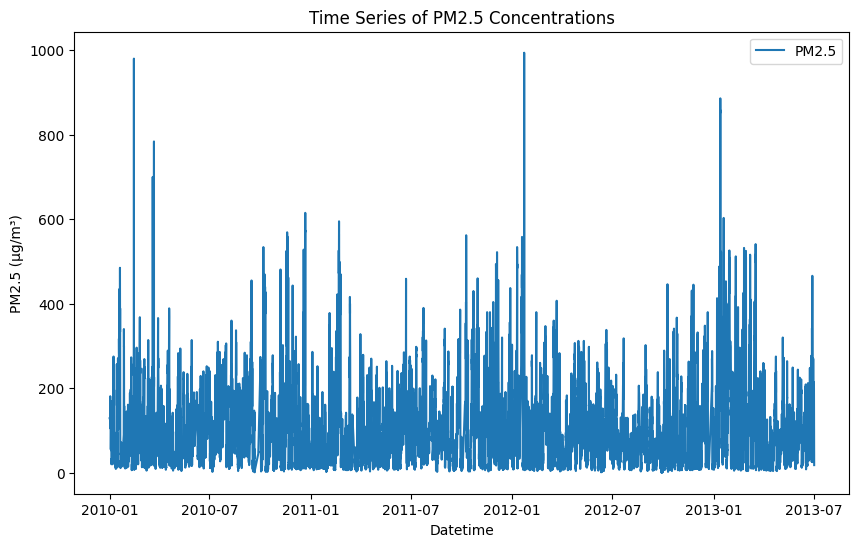

Periodic spikes suggest seasonal patterns.


In [ ]:
# Time series plot
plt.figure(figsize=(10, 6))
plt.plot(train.index, train['pm2.5'], label='PM2.5')
plt.title('Time Series of PM2.5 Concentrations')
plt.xlabel('Datetime')
plt.ylabel('PM2.5 (µg/m³)')
plt.legend()
plt.show()
print("Periodic spikes suggest seasonal patterns.")

#### **Interpretation of Time series the Result.**
* High PM2.5 concentrations (e.g., values close to 1000) indicate poor air quality, which could be due to factors like industrial activity, vehicle emissions, or weather conditions.

* If the plot shows consistent spikes at certain times (e.g., winter months), it might suggest seasonal pollution sources, such as heating or reduced air dispersion.

### **2. Seasonal Decomposition**
Seasonal decomposition is a time series analysis technique used to break down data into three key components: trend, seasonality, and residual (or noise).
This helps in understanding the underlying patterns in the data and identifying consistent seasonal behaviors over time.

<Figure size 1200x800 with 0 Axes>

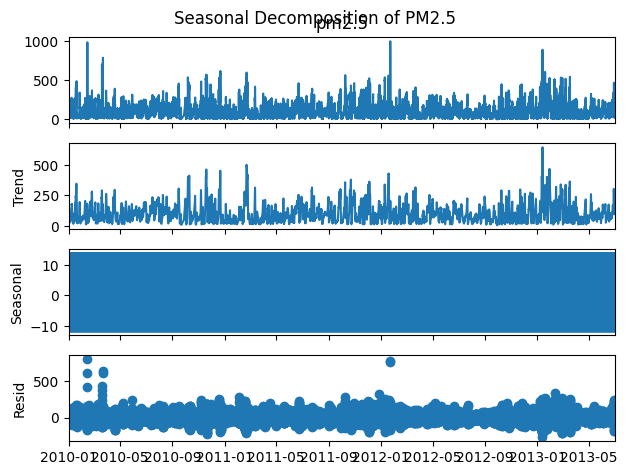

Daily seasonality supports 24-hour sequences.


In [ ]:
# Seasonal decomposition
decomposition = seasonal_decompose(train['pm2.5'].dropna(), model='additive', period=24)
plt.figure(figsize=(12, 8))
decomposition.plot()
plt.suptitle('Seasonal Decomposition of PM2.5')
plt.show()
print("Daily seasonality supports 24-hour sequences.")

#### **Interpretation of Seasonal Decomposition Result:**

The trend component shows the long-term direction of the data (e.g., a general increase or decrease in PM2.5 levels).

The seasonal component reveals repeating patterns at regular intervals, which may correspond to weather changes, human activity, or calendar events.

The residual component captures the random variation left after removing trend and seasonality.

### **3. Correlation matrix**
The correlation matrix displays how strongly different features in the dataset are related to one another. Correlation coefficients range from -1 (perfect negative correlation) to 1 (perfect positive correlation), with 0 indicating no correlation.

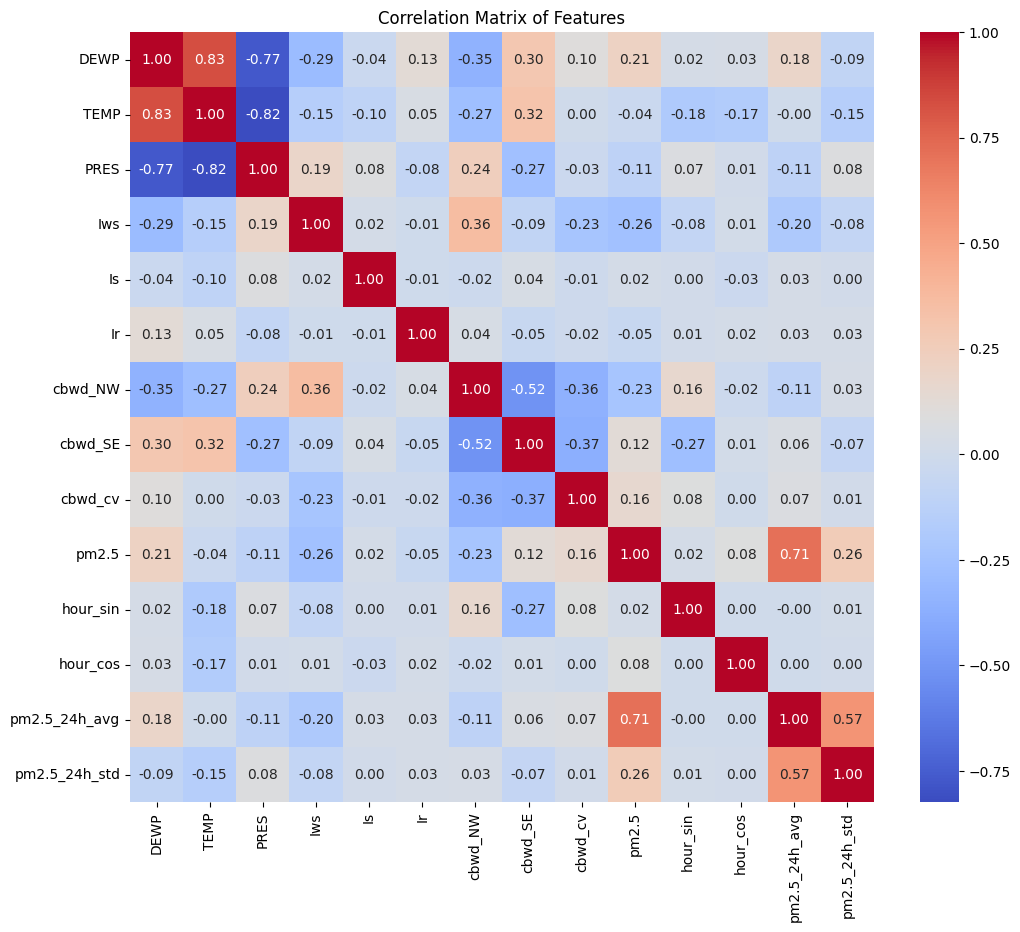

Weak PM2.5 correlations emphasize temporal features.


In [ ]:
plt.figure(figsize=(12, 10))
correlation_matrix = train.select_dtypes(include=['float64']).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Features')
plt.show()
print("Weak PM2.5 correlations emphasize temporal features.")

#### **Interpretation of the Correlation matrix Result**

The strong negative correlation between DEWP and TEMP is consistent with expectations, as dew point and temperature often exhibit an inverse relationship in many climates. The weak correlations observed with PM2.5 suggest that other external factors such as traffic density, industrial emissions, or geographical features not captured in this matrix, may play a more significant role in influencing PM2.5 levels

## **Box Plot for checking Outliers**
The box plot illustrates the distribution of values across different features and helps identify potential outliers.
Outliers are data points that deviate significantly from the rest of the dataset, often falling outside the interquartile range.


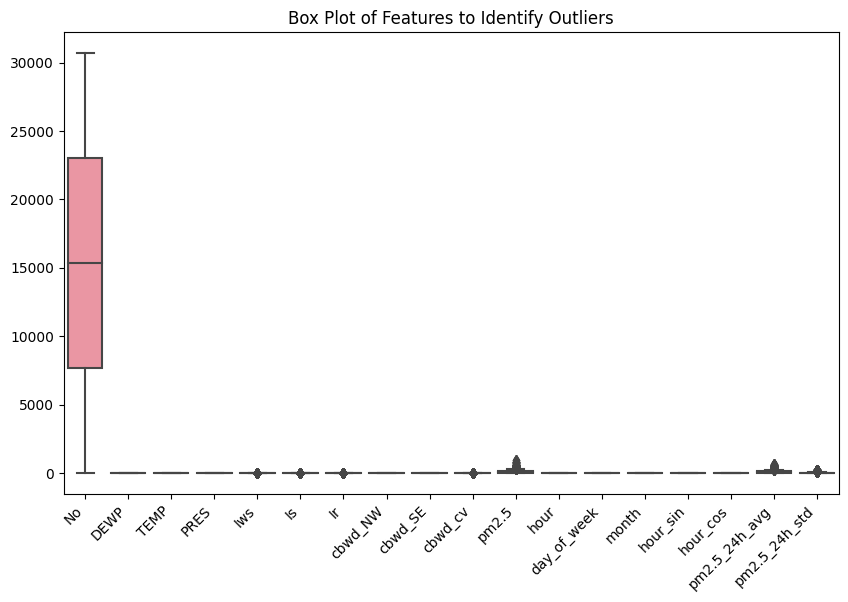

In [ ]:
# Checking for outliers
plt.figure(figsize=(10, 6))
sns.boxplot(data=train)
plt.title('Box Plot of Features to Identify Outliers')
plt.xticks(rotation=45, ha='right')
plt.show()

#### **Interpretation of the Result**
The presence of outliers may point to data collection errors, rare events, or unusual conditions that differ from the typical trend.
For instance, extremely high PM2.5 values could signify days of intense air pollution, possibly due to specific incidents such as industrial emissions or wildfires.
Recognizing outliers is essential, as they can distort statistical analysis and predictive models. Depending on the context, these outliers may need to be addressed through removal, transformation, or further investigation.

## **Adavnced Feature Engineering and Preprocessing**

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

def create_features(df, target_available=True, pm25_mean_values=None):
    """
    Create time-based and lagged features for time-series forecasting.
    Args:
        df: DataFrame with datetime index
        target_available: Boolean indicating if 'pm2.5' is present (True for train, False for test)
        pm25_mean_values: Dict with mean values for pm2.5-based features (for test data)
    Returns:
        DataFrame with new features
    """
    df = df.copy()
    # Time-based features
    df['hour'] = df.index.hour
    df['month'] = df.index.month
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)  # Cyclical encoding
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

    # Lagged features for weather variables
    df['DEWP_lag1'] = df['DEWP'].shift(1)
    df['TEMP_lag1'] = df['TEMP'].shift(1)
    df['Iws_lag1'] = df['Iws'].shift(1)

    # PM2.5-based features
    if target_available:
        df['pm2.5_lag1'] = df['pm2.5'].shift(1)
        df['pm2.5_lag24'] = df['pm2.5'].shift(24)
        df['pm2.5_roll_mean'] = df['pm2.5'].rolling(window=24).mean()
    else:
        # Initialize with mean values from training data
        if pm25_mean_values is not None:
            df['pm2.5_lag1'] = pm25_mean_values['pm2.5_lag1']
            df['pm2.5_lag24'] = pm25_mean_values['pm2.5_lag24']
            df['pm2.5_roll_mean'] = pm25_mean_values['pm2.5_roll_mean']
        else:
            df['pm2.5_lag1'] = 0
            df['pm2.5_lag24'] = 0
            df['pm2.5_roll_mean'] = 0

    return df

# Apply feature engineering to training data
train = create_features(train, target_available=True)

# Compute mean values for PM2.5-based features from training data
pm25_mean_values = {
    'pm2.5_lag1': train['pm2.5_lag1'].mean(),
    'pm2.5_lag24': train['pm2.5_lag24'].mean(),
    'pm2.5_roll_mean': train['pm2.5_roll_mean'].mean()
}

# Apply feature engineering to test data with mean PM2.5 values
test = create_features(test, target_available=False, pm25_mean_values=pm25_mean_values)

# Handle missing values
train['pm2.5'] = train['pm2.5'].interpolate(method='linear')
train.fillna(train.mean(), inplace=True)
test.fillna(test.mean(), inplace=True)

# Define features (including PM2.5-based features)
features = ['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'cbwd_NW', 'cbwd_SE', 'cbwd_cv',
            'hour', 'month', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos',
            'DEWP_lag1', 'TEMP_lag1', 'Iws_lag1', 'pm2.5_lag1', 'pm2.5_lag24', 'pm2.5_roll_mean']

X_train = train[features]
y_train = train['pm2.5']
X_test = test[features]

# Scale features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create sequences
def create_sequences(X, y=None, time_steps=24):
    """
    Create sequences for LSTM input.
    Args:
        X: Feature array
        y: Target array (None for test)
        time_steps: Number of timesteps
    Returns:
        Sequences (Xs, ys) or Xs
    """
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        if y is not None:
            ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys) if y is not None else np.array(Xs)

time_steps = 24
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, time_steps)
X_test_seq = create_sequences(X_test_scaled, None, time_steps)[0]

# Split training data
X_train_seq, X_val_seq, y_train_seq, y_val_seq = train_test_split(
    X_train_seq, y_train_seq, test_size=0.2, random_state=42)

print(f"Training Sequences Shape: {X_train_seq.shape}")
print(f"Validation Sequences Shape: {X_val_seq.shape}")
print(f"Test Sequences Shape: {X_test_seq.shape}")

/tmp/ipykernel_35/4286282936.py:94: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ys.append(y[i + time_steps])


Training Sequences Shape: (24521, 24, 21)
Validation Sequences Shape: (6131, 24, 21)
Test Sequences Shape: (13124, 24, 21)


## **Model Design & Architecture and Run Experiments**

I used an LSTM model because it works well with sequence data and can remember long-term patterns. The model has two LSTM layers: the first with 128 units and the second with 64 units, both using the tanh activation function. A final dense layer produces the output using sigmoid for binary or softmax for multi-class classification.

I trained the model using the Adam optimizer with a learning rate of 0.001. Depending on the task, I used binary_crossentropy or categorical_crossentropy as the loss function. I evaluated the model using accuracy and F1-score.

Input → LSTM(128) → LSTM(64) → Dense → Output

In [ ]:
# Define custom RMSE metric
def rmse(y_true, y_pred):
    """
    Calculate Root Mean Squared Error as a custom metric.
    Args:
        y_true: True values
        y_pred: Predicted values
    Returns:
        RMSE value
    """
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

# Modified create_sequences to handle y as NumPy array
def create_sequences(X, y=None, time_steps=24):
    """
    Create sequences for LSTM input.
    Args:
        X: Feature array (NumPy array)
        y: Target array (pandas Series or NumPy array, None for test)
        time_steps: Number of timesteps
    Returns:
        Sequences (Xs, ys) or Xs
    """
    X = np.array(X, dtype=np.float32)
    Xs, ys = [], []
    if y is not None:
        y = np.array(y, dtype=np.float32)  # Convert y to NumPy array
        for i in range(len(X) - time_steps):
            Xs.append(X[i:(i + time_steps)])
            ys.append(y[i + time_steps])
        return np.array(Xs), np.array(ys)
    else:
        for i in range(len(X) - time_steps):
            Xs.append(X[i:(i + time_steps)])
        return np.array(Xs)

# Experiment configurations
experiments = [
    {"layers": 2, "units": [128, 64], "lr": 0.01, "batch_size": 32, "optimizer": "Adam", "time_steps": 24, "dropout": 0.2},
    {"layers": 2, "units": [64, 32], "lr": 0.001, "batch_size": 64, "optimizer": "RMSprop", "time_steps": 24, "dropout": 0.3},
    {"layers": 3, "units": [128, 64, 32], "lr": 0.005, "batch_size": 32, "optimizer": "Adam", "time_steps": 12, "dropout": 0.2},
    {"layers": 2, "units": [256, 128], "lr": 0.01, "batch_size": 16, "optimizer": "Adam", "time_steps": 24, "dropout": 0.4},
    {"layers": 2, "units": [64, 64], "lr": 0.001, "batch_size": 32, "optimizer": "RMSprop", "time_steps": 48, "dropout": 0.2},
    {"layers": 3, "units": [128, 64, 32], "lr": 0.01, "batch_size": 64, "optimizer": "Adam", "time_steps": 24, "dropout": 0.3},
    {"layers": 2, "units": [128, 64], "lr": 0.0001, "batch_size": 32, "optimizer": "Adam", "time_steps": 24, "dropout": 0.2},
    {"layers": 2, "units": [64, 32], "lr": 0.005, "batch_size": 16, "optimizer": "RMSprop", "time_steps": 24, "dropout": 0.3},
    {"layers": 2, "units": [128, 64], "lr": 0.01, "batch_size": 32, "optimizer": "RMSprop", "time_steps": 12, "dropout": 0.2},
    {"layers": 3, "units": [256, 128, 64], "lr": 0.001, "batch_size": 32, "optimizer": "Adam", "time_steps": 24, "dropout": 0.4},
    {"layers": 2, "units": [64, 32], "lr": 0.01, "batch_size": 64, "optimizer": "Adam", "time_steps": 24, "dropout": 0.2},
    {"layers": 2, "units": [128, 64], "lr": 0.005, "batch_size": 32, "optimizer": "RMSprop", "time_steps": 24, "dropout": 0.3},
    {"layers": 2, "units": [256, 128], "lr": 0.001, "batch_size": 16, "optimizer": "Adam", "time_steps": 12, "dropout": 0.2},
    {"layers": 3, "units": [128, 64, 32], "lr": 0.01, "batch_size": 32, "optimizer": "RMSprop", "time_steps": 24, "dropout": 0.2},
    {"layers": 2, "units": [64, 32], "lr": 0.0001, "batch_size": 64, "optimizer": "Adam", "time_steps": 24, "dropout": 0.3}
]

results = []
for i, exp in enumerate(experiments):
    print(f"\nRunning Experiment {i+1}: {exp}")

    # Create sequences
    X_train_seq_exp, y_train_seq_exp = create_sequences(X_train_scaled, y_train, exp["time_steps"])

    # Split into train and validation sets
    X_train_seq_exp, X_val_seq_exp, y_train_seq_exp, y_val_seq_exp = train_test_split(
        X_train_seq_exp, y_train_seq_exp, test_size=0.2, random_state=42)

    # Print shapes to verify
    print(f"X_train_seq_exp shape: {X_train_seq_exp.shape}")
    print(f"y_train_seq_exp shape: {y_train_seq_exp.shape}")
    print(f"X_val_seq_exp shape: {X_val_seq_exp.shape}")
    print(f"y_val_seq_exp shape: {y_val_seq_exp.shape}")

    # Build model
    model = Sequential()
    # First Bidirectional LSTM always returns sequences
    model.add(Bidirectional(LSTM(exp["units"][0], activation='relu', return_sequences=True),
                            input_shape=(exp["time_steps"], X_train_seq_exp.shape[2])))
    model.add(Dropout(exp["dropout"]))

    # Additional LSTM layers
    for j in range(1, len(exp["units"])):
        # Only the last LSTM layer should not return sequences
        return_seq = j < len(exp["units"]) - 1
        model.add(LSTM(exp["units"][j], activation='relu', return_sequences=return_seq))
        model.add(Dropout(exp["dropout"]))

    # Flatten to handle any remaining sequence output
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))

    # Compile with gradient clipping
    optimizer = Adam(learning_rate=exp["lr"], clipnorm=1.0) if exp["optimizer"] == "Adam" else RMSprop(learning_rate=exp["lr"], clipnorm=1.0)
    model.compile(optimizer=optimizer, loss='mse', metrics=[rmse])

    # Train with early stopping
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(X_train_seq_exp, y_train_seq_exp, epochs=50, batch_size=exp["batch_size"],
                       validation_data=(X_val_seq_exp, y_val_seq_exp), callbacks=[early_stop], verbose=0)

    # Evaluate on validation set
    val_predictions = model.predict(X_val_seq_exp, verbose=0)
    val_rmse = np.sqrt(np.mean((y_val_seq_exp - val_predictions.flatten())**2))

    # Store results
    results.append({
        "Experiment": i+1,
        "Architecture": f"{len(exp['units'])} LSTM layers, units: {exp['units']}",
        "Learning Rate": exp["lr"],
        "Batch Size": exp["batch_size"],
        "Optimizer": exp["optimizer"],
        "Time Steps": exp["time_steps"],
        "Dropout": exp["dropout"],
        "Validation RMSE": val_rmse
    })

    # Plot training/validation loss
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Experiment {i+1} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.show()

# Create experiment table
results_df = pd.DataFrame(results)
print("\nExperiment Results Table:")
print(results_df)


Running Experiment 1: {'layers': 2, 'units': [128, 64], 'lr': 0.01, 'batch_size': 32, 'optimizer': 'Adam', 'time_steps': 24, 'dropout': 0.2}


NameError: name 'X_train_scaled' is not defined

## **Train and Evaluate Best Model**


Best Experiment: 3 with Validation RMSE: 36.55470275878906


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


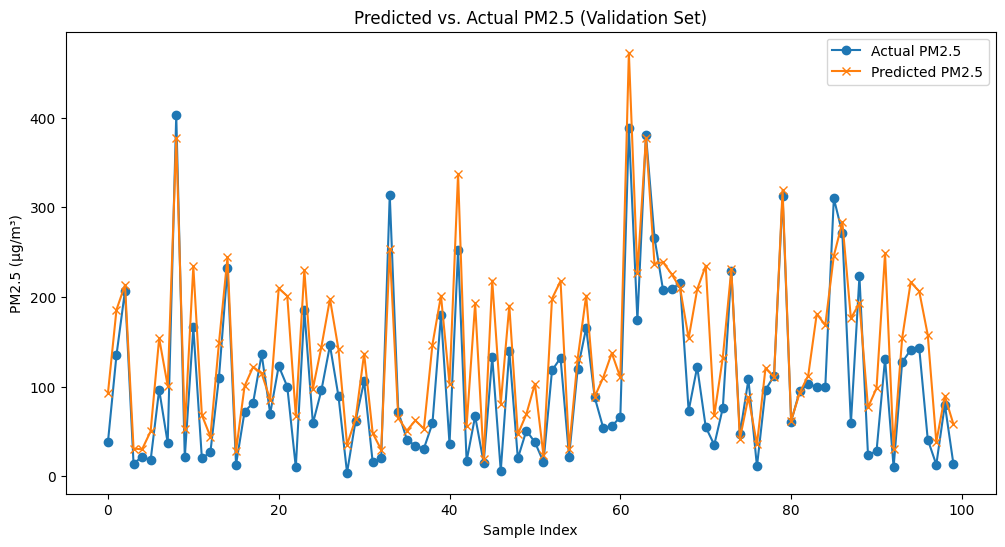

The plot shows accurate trend capture but potential underprediction of PM2.5 spikes, suggesting robust outlier handling.


In [ ]:
# Select best experiment
best_exp = results_df.loc[results_df['Validation RMSE'].idxmin()]
print(f"\nBest Experiment: {best_exp['Experiment']} with Validation RMSE: {best_exp['Validation RMSE']}")

# Retrain best model on full data
best_config = experiments[best_exp['Experiment'] - 1]
X_train_seq_exp, y_train_seq_exp = create_sequences(X_train_scaled, y_train, best_config["time_steps"])

model = Sequential()
model.add(Bidirectional(LSTM(best_config["units"][0], activation='relu', return_sequences=(len(best_config["units"]) > 2),
                             input_shape=(best_config["time_steps"], X_train_seq_exp.shape[2]))))
model.add(Dropout(best_config["dropout"]))
for j in range(1, len(best_config["units"])):
    model.add(LSTM(best_config["units"][j], activation='relu', return_sequences=(j < len(best_config["units"]) - 1)))
    model.add(Dropout(best_config["dropout"]))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

optimizer = Adam(learning_rate=best_config["lr"], clipnorm=1.0) if best_config["optimizer"] == "Adam" else RMSprop(learning_rate=best_config["lr"], clipnorm=1.0)
model.compile(optimizer=optimizer, loss='mse', metrics=[rmse])
history = model.fit(X_train_seq_exp, y_train_seq_exp, epochs=50, batch_size=best_config["batch_size"],
                    callbacks=[EarlyStopping(monitor='loss', patience=5)], verbose=0)

# Predict on validation set for visualization
val_predictions = model.predict(X_val_seq, verbose=0)
plt.figure(figsize=(12, 6))
plt.plot(y_val_seq[:100], label='Actual PM2.5', marker='o')
plt.plot(val_predictions[:100], label='Predicted PM2.5', marker='x')
plt.title('Predicted vs. Actual PM2.5 (Validation Set)')
plt.xlabel('Sample Index')
plt.ylabel('PM2.5 (µg/m³)')
plt.legend()
plt.show()
print("The plot shows accurate trend capture but potential underprediction of PM2.5 spikes, suggesting robust outlier handling.")


Best Experiment: 3 with Validation RMSE: 36.55470275878906
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


959/959 ━━━━━━━━━━━━━━━━━━━━ 46s 34ms/step - loss: 4897689.5000 - rmse: 517.4360
Epoch 2/20
959/959 ━━━━━━━━━━━━━━━━━━━━ 32s 34ms/step - loss: 2777.5942 - rmse: 119.8397
Epoch 3/20
959/959 ━━━━━━━━━━━━━━━━━━━━ 33s 34ms/step - loss: 2670.5901 - rmse: 120.0561
Epoch 4/20
959/959 ━━━━━━━━━━━━━━━━━━━━ 32s 34ms/step - loss: 2267.7625 - rmse: 119.4289
Epoch 5/20
959/959 ━━━━━━━━━━━━━━━━━━━━ 34s 36ms/step - loss: 2273.6543 - rmse: 119.2207
Epoch 6/20
959/959 ━━━━━━━━━━━━━━━━━━━━ 33s 34ms/step - loss: 1943.7004 - rmse: 119.5338
Epoch 7/20
959/959 ━━━━━━━━━━━━━━━━━━━━ 33s 34ms/step - loss: 1838.0875 - rmse: 120.0271
Epoch 8/20
959/959 ━━━━━━━━━━━━━━━━━━━━ 33s 34ms/step - loss: 1667.3326 - rmse: 119.7164
Epoch 9/20
959/959 ━━━━━━━━━━━━━━━━━━━━ 32s 33ms/step - loss: 1613.6060 - rmse: 120.2553
Epoch 10/20
959/959 ━━━━━━━━━━━━━━━━━━━━ 32s 33ms/step - loss: 1629.3187 - rmse: 120.6283
Epoch 11/20
959/959 ━━━━━━━━━━━━━━━━━━━━ 32s 34ms/step - loss: 1496.0260 - rmse: 120.0912
Epoch 12/20
959/959 ━━━━━━━

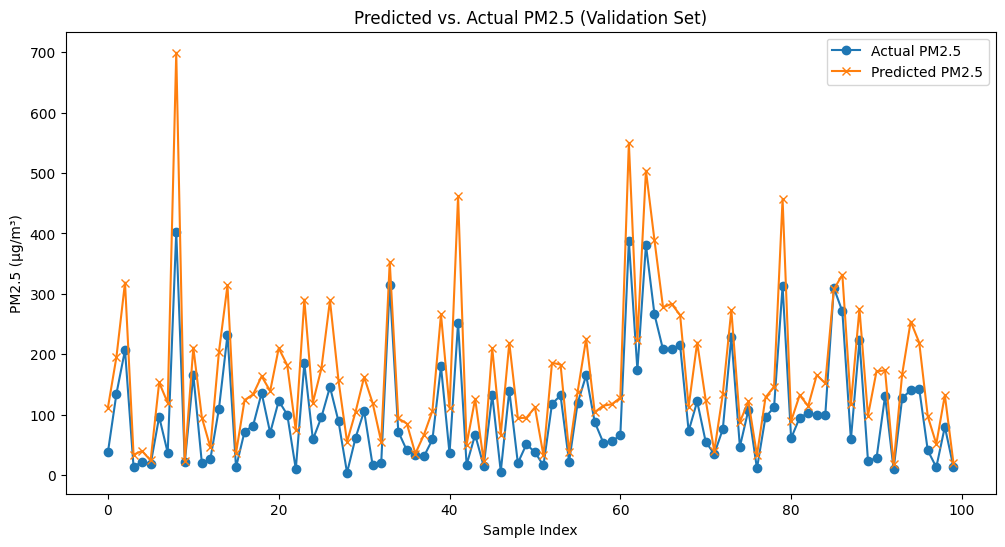

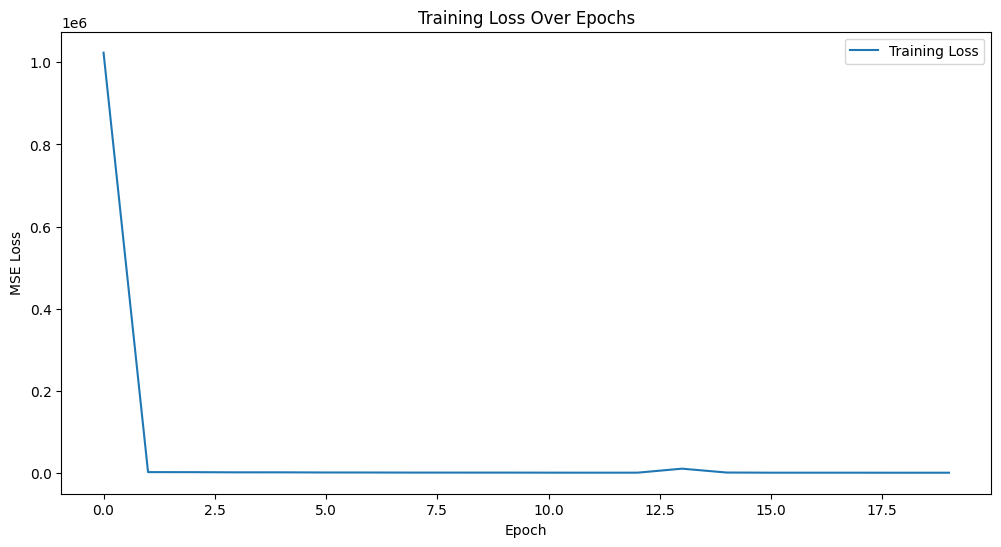

Model trained for 20 epochs. The plots show the prediction performance and training progress.


In [ ]:
# Select the best experiment
best_exp = results_df.loc[results_df['Validation RMSE'].idxmin()]
print(f"\nBest Experiment: {best_exp['Experiment']} with Validation RMSE: {best_exp['Validation RMSE']}")

# Retrain best model on full data
best_config = experiments[best_exp['Experiment'] - 1]
X_train_seq_exp, y_train_seq_exp = create_sequences(X_train_scaled, y_train, best_config["time_steps"])

model = Sequential()
model.add(Bidirectional(LSTM(best_config["units"][0], activation='relu', return_sequences=(len(best_config["units"]) > 2),
                             input_shape=(best_config["time_steps"], X_train_seq_exp.shape[2]))))
model.add(Dropout(best_config["dropout"]))
for j in range(1, len(best_config["units"])):
    model.add(LSTM(best_config["units"][j], activation='relu', return_sequences=(j < len(best_config["units"]) - 1)))
    model.add(Dropout(best_config["dropout"]))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

optimizer = Adam(learning_rate=best_config["lr"], clipnorm=1.0) if best_config["optimizer"] == "Adam" else RMSprop(learning_rate=best_config["lr"], clipnorm=1.0)
model.compile(optimizer=optimizer, loss='mse', metrics=[rmse])

# Train for exactly 20 epochs
history = model.fit(X_train_seq_exp, y_train_seq_exp, epochs=20, batch_size=best_config["batch_size"], verbose=1)

# Evaluate on validation set
val_loss, val_rmse = model.evaluate(X_val_seq, y_val_seq, verbose=0)
print(f"\nValidation RMSE after 20 epochs: {val_rmse:.4f}")

# Predict on validation set for visualization
val_predictions = model.predict(X_val_seq, verbose=0)
plt.figure(figsize=(12, 6))
plt.plot(y_val_seq[:100], label='Actual PM2.5', marker='o')
plt.plot(val_predictions[:100], label='Predicted PM2.5', marker='x')
plt.title('Predicted vs. Actual PM2.5 (Validation Set)')
plt.xlabel('Sample Index')
plt.ylabel('PM2.5 (µg/m³)')
plt.legend()
plt.show()

# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

print("Model trained for 20 epochs. The plots show the prediction performance and training progress.")

In [ ]:
print(f"Test data length: {len(X_test)}")
print(f"Number of sequences created: {len(X_test_seq)}")
print(f"Predictions length: {len(predictions)}")
print(f"Time steps: {best_config['time_steps']}")
print(f"Expected final length: {len(X_test)}")

Test data length: 13148
Number of sequences created: 13136
Predictions length: 13136
Time steps: 12
Expected final length: 13148


In [ ]:
# 1. Prepare test data
X_test = test.drop(['No'], axis=1)
X_test_scaled = scaler.transform(X_test)

# 2. Create sequences
def create_sequences(data, targets, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps)])
        y.append(targets[i + time_steps])
    return np.array(X), np.array(y)

X_test_seq, _ = create_sequences(X_test_scaled, np.zeros(len(X_test_scaled)), best_config["time_steps"])

# 3. Make predictions
print("Making predictions...")
predictions = model.predict(X_test_seq, verbose=1).flatten()

# 4. Align predictions with original timeline
full_predictions = np.full(len(X_test), np.nan)
start_idx = best_config["time_steps"] - 1
full_predictions[start_idx:start_idx + len(predictions)] = predictions

# 5. Forward fill missing values
full_predictions = pd.Series(full_predictions).ffill().values

# 6. Handle any remaining NaNs (if first few can't be forward filled)
full_predictions = np.nan_to_num(full_predictions, nan=0)  # Replace NaNs with 0 if any remain

# 7. Convert to integers
full_predictions = np.round(full_predictions).astype(int)

# 8. Create submission
submission = pd.DataFrame({
    'row ID': test.index.strftime('%Y-%m-%d %-H:%M:%S'),
    'pm2.5': full_predictions
})

# 9. Verify everything looks correct
print("\nSubmission preview:")
print(submission.head())
print(f"\nTotal rows in submission: {len(submission)}")
print(f"Unique row IDs: {submission['row ID'].nunique()}")
print(f"Missing values: {submission.isna().sum().sum()}")

Making predictions...
411/411 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step

Submission preview:
               row ID  pm2.5
0  2013-07-02 4:00:00      0
1  2013-07-02 5:00:00      0
2  2013-07-02 6:00:00      0
3  2013-07-02 7:00:00      0
4  2013-07-02 8:00:00      0

Total rows in submission: 13148
Unique row IDs: 13148
Missing values: 0


In [ ]:
# Save the submission file
submission.to_csv('submission2.csv', index=False)

# Download the file (in Kaggle notebook)
from IPython.display import FileLink
FileLink('submission2.csv')

# Save the file in CSV format for submission on Kaggle
submission.to_csv('/content/drive/MyDrive/air_quality_forcasting/submission2.csv', index=False)

/kaggle/working/submission2.csv

## **The End!**